# Se você é novo por aqui instale os seguintes pacotes:

In [83]:
!pip install odfpy
!pip install mpl_scatter_density
!pip install uncertainties
!pip install plotly.express

# Importação de bibliotecas e configurações gerais

In [84]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
import warnings
import uncertainties as u
from uncertainties import unumpy
from scipy.stats import spearmanr
import math
import matplotlib.pyplot as plt
import mpl_scatter_density
from matplotlib.colors import LinearSegmentedColormap
from plotly.subplots import make_subplots
import sklearn.metrics as skm

plt.style.use('default')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

#Configurações gerais de display e exportação
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')
warnings.filterwarnings("ignore")
username = "theweckerle"
api_key = "liegKf44ZIsiHYKJ9nrH"
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

pd.set_option("display.max_rows", None, "display.max_columns", None, 'display.width', 1000)
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:60% !important; }</style>"))
#display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
#display(HTML("<style>.prompt { display:none !important; }</style>"))

# Importando os dados

In [85]:
data = pd.read_excel(r'C:\Users\joaow.000\Downloads\abundancias_def_def.ods', sheet_name='Params_and_Abun',  index_col=0)
foto = pd.read_excel(r'C:\Users\joaow.000\Downloads\abundancias_def_def.ods', sheet_name='Fotometria_e_Astrometria', index_col=0)
data = data.fillna(np.nan)
#Atmospheric Parameters
feh=data['[Fe/H]']
logg=data['LOGG']
vmic=data['VMIC']
teff=data['TEFF']
#Abundances
o=data['O I']
na=data['Na I']
mg=data['Mg I']
al=data['Al I']
si=data['Si I']
ca=data['Ca I']
ti=data['Ti I']
tii=data['Ti II']
fei=data['Fe I']
feii=data['Fe II']
ni=data['Ni I']
#Photometries
UV=foto['U-V']
BV=foto['B-V']
bv0=foto['(B-V)0']
bv0hip=foto['(B-V)0_hip']
#Uncertainties
teffinc=data['Δteff']
logginc=data['Δlogg']
fehinc=data['Δ[Fe/H]']
vmicinc=data['Δvmic']
vmicinc=pd.to_numeric(vmicinc, errors='coerce')
oinc=data['ΔO I']
nainc=data['ΔNa I']
mginc=data['ΔMg I']
alinc=data['ΔAl I']
siinc=data['ΔSi I']
cainc=data['ΔCa I']
tiinc=data['ΔTi I']
tiiinc=data['ΔTi II']
feiinc=data['ΔFe I']
feiiinc=data['ΔFe II']
niinc=data['ΔNi I']

#Using the uncertainties in the data
teff_inc = unumpy.uarray(teff, teffinc)
logg_inc = unumpy.uarray(logg, logginc)
feh_inc = unumpy.uarray(feh, fehinc)                
vmic_inc = unumpy.uarray(vmic, vmicinc)
o_inc = unumpy.uarray(o, oinc)
na_inc = unumpy.uarray(na, nainc)
mg_inc = unumpy.uarray(mg, mginc)
al_inc = unumpy.uarray(al, alinc)
si_inc = unumpy.uarray(si, siinc)
ca_inc = unumpy.uarray(ca, cainc)
ti_inc = unumpy.uarray(ti, tiinc)
tii_inc = unumpy.uarray(tii, tiiinc)
fe_inc = unumpy.uarray(fei, feiinc)
feii_inc = unumpy.uarray(feii, feiiinc)
ni_inc = unumpy.uarray(ni, niinc)


# Definindo valores solares e calculando [Alpha/Fe]

In [86]:
##Defining solar values
o_solar=u.ufloat(8.69, 0.04)
na_solar=u.ufloat(6.22,0.03)
mg_solar=u.ufloat(7.55,0.03)
al_solar=u.ufloat(6.43,0.03)
si_solar=u.ufloat(7.51,0.03)
ca_solar=u.ufloat(6.30,0.03)
ti_solar=u.ufloat(4.97,0.05)
fe_solar=u.ufloat(7.46,0.04)
ni_solar=u.ufloat(6.20,0.04)


alfamed=(mg_solar+ca_solar+ti_solar+si_solar)/4
alfa_solar=(alfamed - fe_solar)
abun_ti=[]
abun_fe=[]
alfa_star=[]
s=[mg_inc,si_inc,ca_inc,ti_inc]




##Defining the Fe and Ti abundance as the mean of all states
for i in range(len(ti)):    
    if True == math.isnan(ti_inc[i].nominal_value):
        abun_ti.append(tii_inc[i])
    else:
        abun_ti.append((ti_inc[i]+tii_inc[i]) / 2)
abun_fe=(fe_inc+feii_inc)/2   

o_fe=o_inc-fe_inc-o_solar+fe_solar
na_fe=na_inc-fe_inc-na_solar+fe_solar
mg_fe=mg_inc-fe_inc-mg_solar+fe_solar
al_fe=al_inc-fe_inc-al_solar+fe_solar
si_fe=si_inc-fe_inc-si_solar+fe_solar
ca_fe=ca_inc-fe_inc-ca_solar+fe_solar
ti_fe=abun_ti-fe_inc-ti_solar+fe_solar
si_fe=si_inc-fe_inc-si_solar+fe_solar

# Defining alpha
alfa_star=pd.Series((mg_inc+ca_inc+abun_ti+si_inc)/4, index=data.index, name='alpha')
alfa_star49=(mg_inc[49]+ca_inc[49]+tii_inc[49])/3
alfa_star[49]=alfa_star49

#Defining [Alpha/Fe]
alfa_def=[]
for i in range(len(alfa_star)):
    alfa_def.append((alfa_star[i]-abun_fe[i]) - alfa_solar)
print(repr(alfa_def))
        
alfa_def=pd.Series(alfa_def, name="alpha/fe",  index=data.index)
#np.savetxt('arr.txt', alfa_def, fmt='%r')








[0.07137499999999974+/-0.09799306416782773, -0.047875000000000334+/-0.11323164862351869, -0.0151249999999985+/-0.13646456728762965, -0.0881249999999989+/-0.10650850904974683, -0.07824999999999971+/-0.0987707256731467, 0.10050000000000026+/-0.09118876369926286, -0.006874999999999076+/-0.10609680131841866, 0.2913750000000004+/-0.09351094521498542, 0.051000000000001044+/-0.08533582556581966, 0.008749999999999147+/-0.09772969738006967, 0.11450000000000049+/-0.09274107099877595, 0.3068750000000007+/-0.118916506073239, -0.010500000000000398+/-0.10039391166798911, 0.019999999999999574+/-0.13132700122214033, 0.13150000000000084+/-0.09714770755572844, 0.31975000000000087+/-0.10077601892108723, 0.030250000000001442+/-0.09942157582528721, 0.05262499999999992+/-0.10582387588976948, 0.1662499999999998+/-0.09514676163695746, 0.2782499999999999+/-0.10352910093101038, 0.0837500000000011+/-0.08886761572699022, 0.2576250000000009+/-0.08258291288153985, 0.29287499999999955+/-0.08514334573480578, -0.05025

# Fazendo gráficos de Teff vs (B-V)

In [87]:
##VALUES DISCARDING THE 2 DISTANT POINTS IN (B-V)0
data1= data.drop(index=['HD_45282','HD_171391'] , axis=0)
foto1=foto.drop(index=['HD_45282','HD_171391'], axis=0)

feh1=data1['[Fe/H]']
logg1=data1['LOGG']
vmic1=data1['VMIC']
BV1=foto1['B-V']
teff1=data1['TEFF']
bv01=foto1['(B-V)0']
bv0hip1=foto1['(B-V)0_hip']
alfa_def1=alfa_def.drop(['HD_45282','HD_171391'])


fig1 = px.scatter(y=teff,x=BV, hover_name=data.index, labels="Estrelas feitas", trendline="lowess", color=feh, color_continuous_scale=px.colors.sequential.Inferno)
fig1.update_traces(marker=dict(size=10))
#fig.add_scatter(x=bv_tbd, y= teff_tbd, mode='markers', hovertemplate=id_tbd, name="Estrelas faltantes", marker=dict(color='red'))
fig1.update_xaxes(title_text='B-V', range = [0.2, 1.65])
fig1.update_yaxes(title_text='Teff (K)', range = [3500,7200])
fig1.add_vline(x=1.25)
fig1.add_vline(x=0.4)
fig1.show()



fig2 = px.scatter(y=teff,x=bv0, hover_name=data.index, labels="Estrelas feitas", trendline="lowess", color=feh, color_continuous_scale=px.colors.sequential.Inferno)
fig2.update_traces(marker=dict(size=10))
#fig.add_scatter(x=bv_tbd, y= teff_tbd, mode='markers', hovertemplate=id_tbd, name="Estrelas faltantes", marker=dict(color='red'))
fig2.update_xaxes(title_text='(B-V)_0',range = [0.2, 1.65] )
fig2.update_yaxes(title_text='Teff (K)',range = [3500,7200] )
fig2.add_vline(x=1.25)
fig2.add_vline(x=0.4)
fig2.show()

fig3 = px.scatter(y=teff,x=bv0hip, hover_name=data.index, labels="Estrelas feitas", trendline="lowess", color=feh, color_continuous_scale=px.colors.sequential.Inferno)
fig3.update_traces(marker=dict(size=10))
#fig.add_scatter(x=bv_tbd, y= teff_tbd, mode='markers', hovertemplate=id_tbd, name="Estrelas faltantes", marker=dict(color='red'))
fig3.update_xaxes(title_text='(B-V)_0_hip', )
fig3.update_yaxes(title_text='Teff (K)', )
fig3.add_vline(x=1.25)
fig3.add_vline(x=0.4)
fig3.show()


fig1 = px.scatter(y=teff1,x=bv0hip1, hover_name=data1.index, labels="Estrelas feitas", trendline="lowess", color=feh1, color_continuous_scale=px.colors.sequential.Inferno)
fig1.update_traces(marker=dict(size=10))
fig1.update_coloraxes(colorbar=dict(thickness=14, title="[Fe/H]",
                           ticklen=1, tickcolor='black',
                           tickfont=dict(size=16, color='black')))
fig1.update_xaxes(title_text=r'$\large{(B-V)_0}$', range = [0.35, 1.4], titlefont_size=20, tickfont_size= 14)
fig1.update_yaxes(title_text='Teff (K)', range = [3500,7200],titlefont_size=20, tickfont_size= 14)

## COLOCANDO BARRAS ENVOLTA E DEIXANDO FUNDO TRANSPARENTE
fig1.update_xaxes(mirror=True,
ticks='outside',
linewidth=2, linecolor='black')
fig1.update_yaxes(mirror=True,
ticks='outside',
linewidth=2, linecolor='black')
fig1.show()
fig1.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig1.update_layout(width=1700,height=800)
fig1.write_image("bv0.pdf")



In [88]:
#CHECKING CORRELATIONS BETWEEN ATMOSPHERIC PARAMETERS, B-V AND [ALPHA/FE]
correla=pd.Series([teff[:-1], logg[:-1], vmic[:-1], feh[:-1], alfa_def[:-1] , bv0hip[:-1]])        
for i in correla:
    for j in correla:
        corr, _ = spearmanr(i, j)
        if corr != 1.000:
            if abs(corr) > 0.5:
                print('Spearmans correlation of ',i.name, 'and', j.name, ': %.3f' % corr)
               


Spearmans correlation of  TEFF and LOGG : 0.734
Spearmans correlation of  TEFF and (B-V)0_hip : -0.848
Spearmans correlation of  LOGG and TEFF : 0.734
Spearmans correlation of  LOGG and [Fe/H] : 0.573
Spearmans correlation of  LOGG and alpha/fe : -0.551
Spearmans correlation of  VMIC and [Fe/H] : -0.505
Spearmans correlation of  [Fe/H] and LOGG : 0.573
Spearmans correlation of  [Fe/H] and VMIC : -0.505
Spearmans correlation of  [Fe/H] and alpha/fe : -0.867
Spearmans correlation of  alpha/fe and LOGG : -0.551
Spearmans correlation of  alpha/fe and [Fe/H] : -0.867
Spearmans correlation of  alpha/fe and alpha/fe : 1.000
Spearmans correlation of  (B-V)0_hip and TEFF : -0.848
Spearmans correlation of  (B-V)0_hip and (B-V)0_hip : 1.000


Lembrando que:

[Alpha/Fe] > 0 indica: Pop. II, estrelas do Halo (aglomerados globulares)

[Alpha/Fe] = 0 indica: Pop. I, estrelas do disco (aglomerados abertos / vizinhança solar)

Estrelas com altos valores de [Alpha/Fe] indicam estrelas que foram formadas cedo na história da galáxia, quando a contribuição de SN II ainda era importante

Ou seja, esse gráfico é um traçador temporal da contribuição de SN Ia vs SN II

# Gráfico interativo de [Alpha/Fe] vs [Fe/H]

In [89]:
feh_oxy=feh.drop(index=['HD_150177','Bet_Com', '53_vir', 'HD_45282', 'HIC_57983', 'HD_108577', 'HD_128279',
                        'HD_161770', 'HD_218502', 'HD_122563', 'HD_184266', 'HD_126587'] , axis=0)

feh_na=feh.drop(index=[ 'HD_108577', 'HD_128279', 'HD_218502', 'HD_122563', 'HD_126587', 'HIC_57983'] , axis=0)

feh_al=feh.drop(index=[ 'HD_45282', 'HIC_57983','HD_2796','HD_9051', 'HD_44007', 'HD_93529', 'HD_108577', 'HD_128279',
                        'HD_161770', 'HD_218502', 'HD_122563','HD_204543','HD_184266', 'HD_26297','BD+18_2890','BD+06_0648','HD_124358','HD_126587'] , axis=0)    
   
feh_si=feh.drop(index=[ 'HD_126587'] , axis=0)    
feh_ni=feh.drop(index=[ 'HD_218502','HD_126587'] , axis=0) 

figg = make_subplots(
            rows=5, cols=1,
            #subplot_titles=("Title 1", "Title 2"),
            shared_xaxes=True,
            vertical_spacing =0.01)# tune this value until the two charts don't overlap

figg.add_trace(go.Scatter(x=feh_oxy, y=unumpy.nominal_values(o_fe), mode="markers", hovertext=feh_oxy.index),row=1, col=1)
figg.add_trace(go.Scatter(x=feh, y=unumpy.nominal_values(mg_fe), mode="markers", hovertext=feh.index),row=2, col=1)
figg.add_trace(go.Scatter(x=feh, y=unumpy.nominal_values(si_fe), mode="markers", hovertext=feh.index),row=3, col=1)
figg.add_trace(go.Scatter(x=feh, y=unumpy.nominal_values(ca_fe), mode="markers", hovertext=feh.index),row=4, col=1)
figg.add_trace(go.Scatter(x=feh, y=unumpy.nominal_values(ti_fe), mode="markers", hovertext=feh.index),row=5, col=1)
#MEXENDO NOS PARÂMETROS DO GRAFICO
figg.update_layout(height=1000, width=600, title_text="Gráficos de [X/Fe] vs [Fe/H]", title_x=0.5)
figg.add_vline(x=0, line_width=2, line_dash="dash", line_color="gray", row=1,col=1)
figg.add_vline(x=0, line_width=2, line_dash="dash", line_color="gray", row=2,col=1)
figg.add_vline(x=0, line_width=2, line_dash="dash", line_color="gray", row=3,col=1)
figg.add_vline(x=0, line_width=2, line_dash="dash", line_color="gray", row=4,col=1)
figg.add_vline(x=0, line_width=2, line_dash="dash", line_color="gray", row=5,col=1)
figg.add_hline(y=0, line_width=2, line_dash="dash", line_color="gray", row=1,col=1)
figg.add_hline(y=0, line_width=2, line_dash="dash", line_color="gray", row=2,col=1)
figg.add_hline(y=0, line_width=2, line_dash="dash", line_color="gray", row=3,col=1)
figg.add_hline(y=0, line_width=2, line_dash="dash", line_color="gray", row=4,col=1)
figg.add_hline(y=0, line_width=2, line_dash="dash", line_color="gray", row=5,col=1)


figg.update_yaxes(title_text="[O/Fe]", row=1, col=1, range=[-0.5,0.8])
figg.update_yaxes(title_text="[Mg/Fe]", row=2, col=1,  range=[-0.5,0.8])
figg.update_yaxes(title_text="[Si/Fe]", row=3, col=1, range=[-0.5,0.8])
figg.update_yaxes(title_text="[Ca/Fe]", row=4, col=1,  range=[-0.5,0.8])
figg.update_yaxes(title_text="[Ti/Fe]", row=5, col=1,  range=[-0.5,0.8])
figg.update_xaxes(title_text="[Fe/H]", row=5, col=1)
figg.update(layout_showlegend=False)
figg.update_traces(hovertemplate =feh.index + '<extra></extra>')
figg.update_layout(
    hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
    )
)
figg.write_image("alphas.pdf")
figg.show()


##CRIANDO VETORES SEPARADOS PRA FAZER DUAS REGRESSÕES DISTINTAS
feh_positivo=feh[feh>-1]
feh_negativo=feh[feh<-1]
alfa_positivo=[]
alfa_negativo=[]
for i in range(len(alfa_def)):
    if feh[i]>-1:
        alfa_positivo.append(alfa_def[i])
for i in range(len(alfa_def)):
    if feh[i]<-1:
        alfa_negativo.append(alfa_def[i])
alfa_negativo=pd.Series(alfa_negativo, index=feh_negativo.index)    


#Excluindo valores destoantes
alfa_negativo=alfa_negativo.drop(index=['HD_126587', 'HD_128279'], axis=0)
feh_negativo=feh_negativo.drop(index=['HD_126587', 'HD_128279'], axis=0)

##Criando regressão dos valores de [Fe/H] > -1
regressao_positiva = np.polyfit(unumpy.nominal_values(feh_positivo), unumpy.nominal_values(alfa_positivo), 1)
predict_feh_positiva = np.poly1d(regressao_positiva)
Y3=[]
fehcont1=np.linspace(np.amin(feh_positivo), np.amax(feh_positivo), len(alfa_positivo))
for i in range(len(fehcont1)):
    y=regressao_positiva[0]*fehcont1[i] + regressao_positiva[1]
    Y3.append(y)    

    
##Criando regressão dos valores de [Fe/H] < -1
regressao_negativa = np.polyfit(unumpy.nominal_values(feh_negativo), unumpy.nominal_values(alfa_negativo), 1)
predict_feh_negativa = np.poly1d(regressao_negativa)
Y4=[]
fehcont2=np.linspace(np.amin(feh_negativo), np.amax(feh_negativo), len(alfa_negativo))
for i in range(len(fehcont2)):
    y=regressao_negativa[0]*fehcont2[i] + regressao_negativa[1]
    Y4.append(y)    
    
#Plotando 
fig=px.scatter(x=feh, y=unumpy.nominal_values(alfa_def), trendline_color_override="blue", hover_name=feh.index)
fig.add_trace(go.Scatter(x=fehcont1,y=Y3, mode="lines", line=go.scatter.Line(color="purple"), 
                         name=str(round(float(regressao_positiva[0]), 3)) + '*[Fe/H]  +  '+ str(round(float(regressao_positiva[1]),3))))

fig.update_traces(showlegend=True, selector=dict(mode='lines'))
fig.add_trace(go.Scatter(x=fehcont2,y=Y4, mode="lines", line=go.scatter.Line(color="red"),
                         name=str(round(float(regressao_negativa[0]), 3)) + '*[Fe/H]  +  '+ str(round(float(regressao_negativa[1]),3))))

fig.update_traces(showlegend=True, selector=dict(mode='lines'))
fig.update_layout(legend=dict(x=0.75,y=0.95, traceorder="normal", font=dict(size=20)), height=800, width=1400,)
fig.update_xaxes(title_text='[Fe/H]', range = [-3, 0.3],titlefont_size=26, tickfont_size= 20)
fig.update_yaxes(title_text=r'$\large{[\alpha/Fe]}$' , titlefont_size=24, tickfont_size= 18)
fig.add_vline(x=0, line_width=2, line_dash="dash", line_color="gray")
fig.add_hline(y=0, line_width=2, line_dash="dash", line_color="gray")

## COLOCANDO BARRAS ENVOLTA E DEIXANDO FUNDO TRANSPARENTE
fig.update_xaxes(mirror=True,
ticks='outside',
linewidth=2, linecolor='black')
fig.update_yaxes(mirror=True,
ticks='outside',
linewidth=2, linecolor='black')
fig.show()
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.update_layout(width=1700,height=800)
fig.write_image("alpha.pdf")

py.plot(fig, filename='alpha_global', auto_open=False)


'https://plotly.com/~theweckerle/53/'

# Análise com GALAH DR2

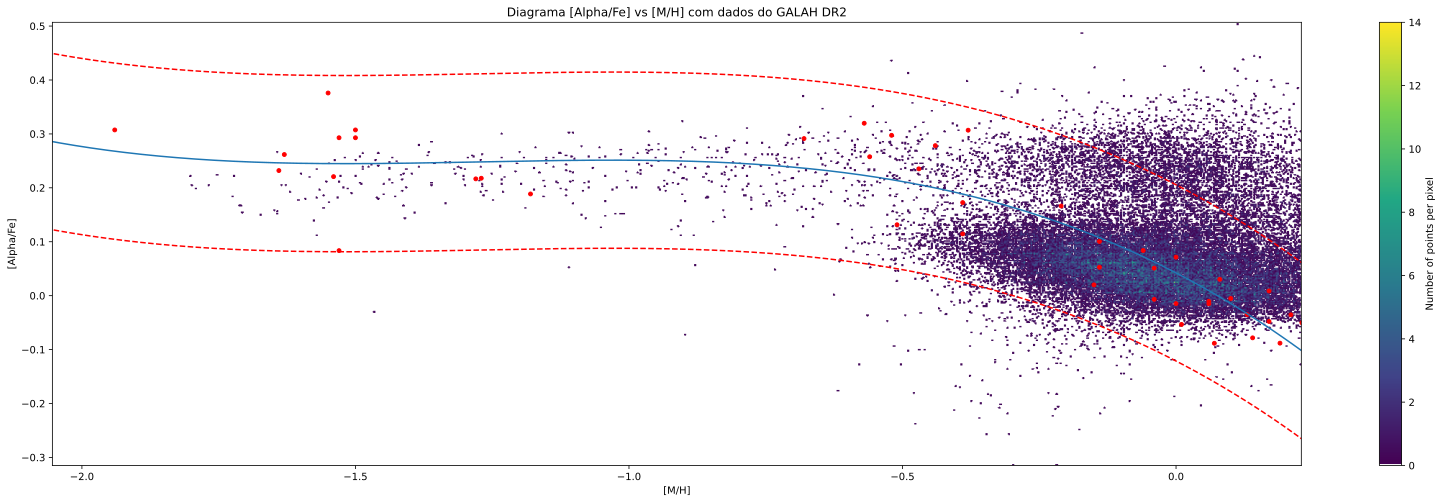

erro percentual medio: 2.1749892912138327
erro quadratico medio: 0.03378862657215436
raiz do erro quadrático médio: 0.1838168288600213
erro medio absoluto: 0.16343826906576728


In [90]:
#IMPORTANDO DADOS
galah = pd.read_csv(r'C:\Users\joaow.000\Downloads\GALAHTESS.csv')
teff_galah=galah['teff']
alpha_fe = galah['alpha_fe']
m_h = galah['m_h']
logg_galah=galah['logg']

#Restrigindo dados para serem compatíveis com a nossa amostra
galah = galah[m_h<np.amax(unumpy.nominal_values(feh))]
galah = galah[teff_galah<np.amax(unumpy.nominal_values(teff))]
galah = galah[np.amin(unumpy.nominal_values(teff))<teff_galah]
galah = galah[np.amin(unumpy.nominal_values(logg))<logg_galah]
galah = galah[logg_galah<np.amax(unumpy.nominal_values(logg))]

teff_galah=galah['teff']
alpha_fe_galah = galah['alpha_fe']
m_h = galah['m_h']
logg_galah=galah['logg']

data1= data.drop(index=['HD_2796','HD_122563', 'HD_126587'] , axis=0)
alpha1=alfa_def.drop(index=['HD_2796','HD_122563', 'HD_126587'] , axis=0)
feh1=data1['[Fe/H]']
logg1=data1['LOGG']
vmic1=data1['VMIC']
erro_logg=data1['Δlogg']
erro_feh=data1['Δ[Fe/H]']

A1 = -0.11186043779E+00
B1 = -0.42746729956E+00
C1 = -0.53771028303E+00
D1 =  0.10611037197E-01


Y=[]
alpha_fe_galah1=alpha_fe_galah.dropna()

fehcont=np.linspace(np.amin(feh1), np.amax(feh1), num=len(alpha_fe_galah1))
loggcont=np.linspace(np.amin(logg1), np.amax(logg1), num=len(alpha_fe_galah1))
for j in range(len(fehcont)):
    y=A1*fehcont[j]**3+B1*fehcont[j]**2+C1*fehcont[j]+D1*loggcont[j]
    Y.append(y)
    

    
###################################################################
#FAZENDO PLOT 
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, m_h, alpha_fe_galah):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(m_h, alpha_fe_galah, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')
fig = plt.figure()
plt.gcf().set_size_inches((28, 8))    
using_mpl_scatter_density(fig, m_h, alpha_fe_galah)
plt.plot(fehcont, Y)
plt.plot(fehcont, Y+skm.mean_absolute_error(Y,unumpy.nominal_values(alpha_fe_galah1)), linestyle='--', c='red')
plt.plot(fehcont, Y-skm.mean_absolute_error(Y,unumpy.nominal_values(alpha_fe_galah1)), linestyle='--', c='red')
plt.xlabel('[M/H]')
plt.ylabel('[Alpha/Fe]')
plt.title('Diagrama [Alpha/Fe] vs [M/H] com dados do GALAH DR2')
plt.scatter(feh, unumpy.nominal_values(alfa_def), s=15, c='red')
#plt.savefig('galah.png')
plt.show()

####################################################################################################################################

print('erro percentual medio:', skm.mean_absolute_percentage_error(Y,unumpy.nominal_values(alpha_fe_galah1)))
print('erro quadratico medio:',skm.mean_squared_error(Y,unumpy.nominal_values(alpha_fe_galah1)))
print('raiz do erro quadrático médio:', np.sqrt(skm.mean_squared_error(Y,unumpy.nominal_values(alpha_fe_galah1))))
print('erro medio absoluto:', skm.mean_absolute_error(Y,unumpy.nominal_values(alpha_fe_galah1)))

#Analisar amostra do nissen & schuster 2010 para verificar validade

# Análise de Nissen & Schuster 2010

In [91]:
nissen = pd.read_csv(r'C:\Users\joaow.000\Downloads\asu.tsv', sep=';')
teff_nissen = nissen['Teff']
logg_nissen = nissen['logg']
feh_nissen = nissen['[Fe/H]']
nafe_nissen = nissen['[Na/Fe]']
mgfe_nissen = nissen['[Mg/Fe]']
sife_nissen = nissen['[Si/Fe]']
cafe_nissen = nissen['[Ca/Fe]']
tife_nissen = nissen['[Ti/Fe]']
nife_nissen = nissen['[Ni/Fe]']
alpha_nissen=(mgfe_nissen+cafe_nissen+sife_nissen+tife_nissen)/4

A1 = -0.11186043779E+00
B1 = -0.42746729956E+00
C1 = -0.53771028303E+00
D1 =  0.10611037197E-01


Y=[]

fehcont=np.linspace(np.amin(feh_nissen), np.amax(feh_nissen), num=len(alpha_nissen))
loggcont=np.linspace(np.amin(logg_nissen), np.amax(logg_nissen), num=len(alpha_nissen))
for j in range(len(fehcont)):
    y=A1*fehcont[j]**3+B1*fehcont[j]**2+C1*fehcont[j]+D1*loggcont[j]
    Y.append(y)

    
fig=px.scatter(x=feh_nissen, y=alpha_nissen, color_continuous_scale=px.colors.sequential.Turbo)
fig.add_trace(go.Scatter(x=fehcont, y=Y, mode="lines", line=go.scatter.Line(color="red"), showlegend=False))
fig.update_xaxes(title_text='[Fe/H]', range = [-1.7, -0.3],titlefont_size=26, tickfont_size= 20)
fig.update_yaxes(title_text=r'$\large{[\alpha/Fe]}$',range = [0, 0.42] ,titlefont_size=26, tickfont_size= 20)

## COLOCANDO BARRAS ENVOLTA E DEIXANDO FUNDO TRANSPARENTE
fig.update_xaxes(mirror=True,
ticks='outside',
linewidth=2, linecolor='black')
fig.update_yaxes(mirror=True,
ticks='outside',
linewidth=2, linecolor='black')
fig.show()
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.update_layout(width=1700,height=800)
fig.write_image("ns10.pdf")

    
print('erro percentual medio:', skm.mean_absolute_percentage_error(Y,alpha_nissen))
print('erro quadratico medio:',skm.mean_squared_error(Y, alpha_nissen))
print('raiz do erro quadrático médio:', np.sqrt(skm.mean_squared_error(Y,alpha_nissen)))
print('erro medio absoluto:', skm.mean_absolute_error(Y,alpha_nissen))    


erro percentual medio: 0.23586591373759996
erro quadratico medio: 0.0053103458529229755
raiz do erro quadrático médio: 0.07287211986022483
erro medio absoluto: 0.060028172611892014


# Usando Asplund 2020:

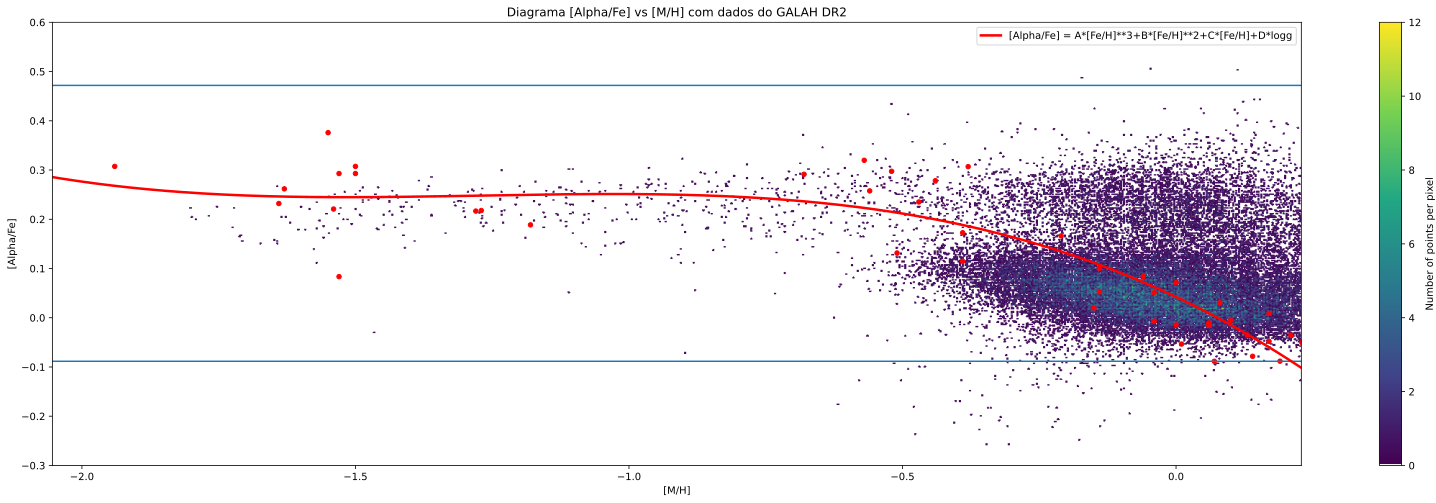

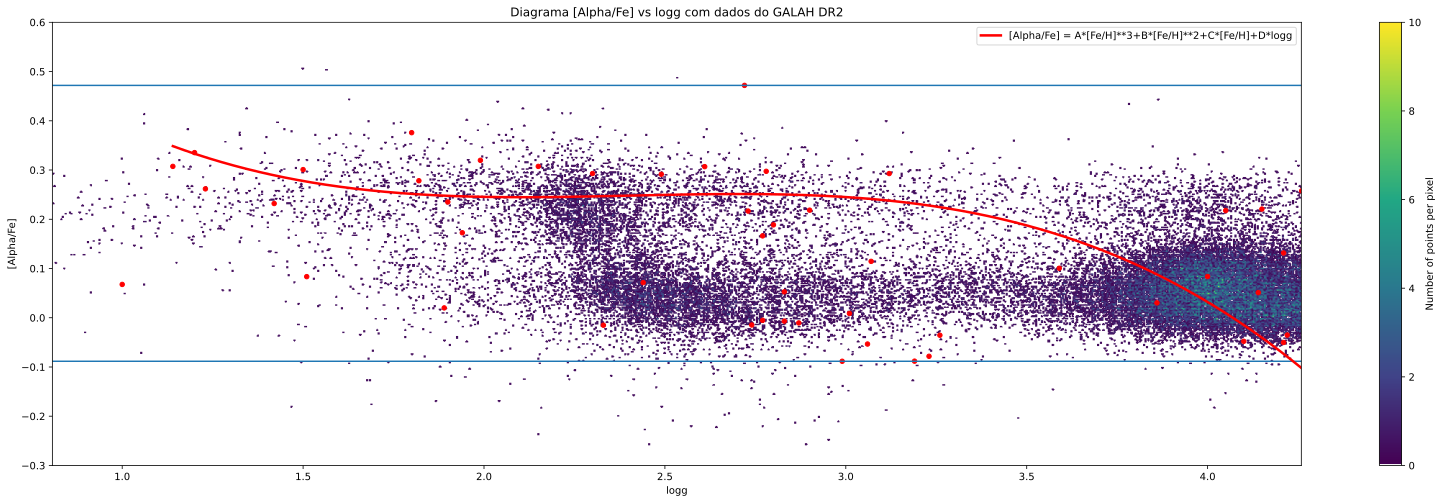

In [92]:
#Y=A*X2**3+B*X2**2+C*X2+D*X1         Red. ChiSq.=0.665292E+00

alpha_fe = galah['alpha_fe']
m_h = galah['m_h']
logg_galah=galah['logg']

Y_2020=[]
data1= data.drop(index=['HD_2796','HD_122563', 'HD_126587'] , axis=0)
alpha1=alfa_def.drop(index=['HD_2796','HD_122563', 'HD_126587'] , axis=0)
feh1=data1['[Fe/H]']
logg1=data1['LOGG']
vmic1=data1['VMIC']
erro_logg=data1['Δlogg']
erro_feh=data1['Δ[Fe/H]']

A1 = -0.11186043779E+00
B1 = -0.42746729956E+00
C1 = -0.53771028303E+00
D1 =  0.10611037197E-01



fehcont=np.linspace(np.amin(feh1), np.amax(feh1), num=1000)
loggcont=np.linspace(np.amin(logg1), np.amax(logg1), num=1000)
for j in range(len(fehcont)):
    y=A1*fehcont[j]**3+B1*fehcont[j]**2+C1*fehcont[j]+D1*loggcont[j]
    Y_2020.append(y)
    

    
#PLOTANDO NO MATPLOTLIB    
#plt.figure(figsize=(25, 6))
#plt.plot(loggcont,Y_2020)  
#plt.scatter(logg1, unumpy.nominal_values(alpha1), c=feh1)
#plt.errorbar(logg1, unumpy.nominal_values(alpha1), xerr=erro_logg, yerr=unumpy.std_devs(alpha1),  fmt='o')

#plt.ylabel('[Alpha/Fe]')
#plt.xlabel('logg')
#plt.ylim(-0.2, 0.6)
#plt.xlim(0.6,4.5)

##GRAFICO VS FEH
fig=px.scatter(x=feh1, y=unumpy.nominal_values(alpha1), color=logg1, color_continuous_scale=px.colors.sequential.Turbo,
               error_x=erro_feh, error_y=unumpy.std_devs(alpha1), hover_name=data1.index)
fig.update_traces(mode='markers', marker_line_width=2, marker_size=10)
fig.add_trace(go.Scatter(
        x=fehcont,
        y=Y_2020,
        mode="lines",
        line=go.scatter.Line(color="red"),
        showlegend=False
        ))
fig.update_xaxes(title_text='[Fe/H]', range = [-2.5, 0.4],titlefont_size=26, tickfont_size= 20)
fig.update_yaxes(title_text=r'$\large{[\alpha/Fe]}$',range = [-0.2, 0.6] ,titlefont_size=26, tickfont_size= 20)
fig.update_layout(height=800, width=1400,)
fig.update_coloraxes(colorbar=dict(thickness=14, title="log(g)",ticklen=1, tickcolor='black',tickfont=dict(size=22, color='black')))


## COLOCANDO BARRAS ENVOLTA E DEIXANDO FUNDO TRANSPARENTE
fig.update_xaxes(mirror=True,
ticks='outside',
linewidth=2, linecolor='black')
fig.update_yaxes(mirror=True,
ticks='outside',
linewidth=2, linecolor='black')
fig.show()
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.update_layout(width=1700,height=800)
fig.write_image("calibration_feh.pdf")
#py.plot(fig, filename='calibration', auto_open=False)

#GRAFICO VS LOGG
fig=px.scatter(x=logg1, y=unumpy.nominal_values(alpha1), color=feh1, color_continuous_scale=px.colors.sequential.Turbo,
               error_x=erro_logg, error_y=unumpy.std_devs(alpha1), hover_name=data1.index)
fig.update_traces(mode='markers', marker_line_width=2, marker_size=10)
fig.add_trace(go.Scatter(
        x=loggcont,
        y=Y_2020,
        mode="lines",
        line=go.scatter.Line(color="red"),
        showlegend=False
        ))
fig.update_xaxes(title_text='log(g)', range = [0.6,4.5],titlefont_size=26, tickfont_size= 20)
fig.update_yaxes(title_text=r'$\large{[\alpha/Fe]}$',range = [-0.2, 0.6] ,titlefont_size=26, tickfont_size= 20)
fig.update_coloraxes(colorbar=dict(thickness=18, title="[Fe/H]",ticklen=1, tickcolor='black',tickfont=dict(size=22, color='black')))

## COLOCANDO BARRAS ENVOLTA E DEIXANDO FUNDO TRANSPARENTE
fig.update_xaxes(mirror=True,
ticks='outside',
linewidth=2, linecolor='black')
fig.update_yaxes(mirror=True,
ticks='outside',
linewidth=2, linecolor='black')
fig.show()
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.update_layout(width=1700,height=800)
fig.write_image("calibration_logg.pdf")


#py.plot(fig, filename='calibration', auto_open=False)

###########GRAFICOS COM GALAH
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)
def using_mpl_scatter_density(fig, m_h, alpha_fe):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(m_h, alpha_fe, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')
fig = plt.figure()
plt.gcf().set_size_inches((28, 8))    
using_mpl_scatter_density(fig, m_h, alpha_fe)
plt.xlabel('[M/H]')
plt.ylabel('[Alpha/Fe]')
plt.title('Diagrama [Alpha/Fe] vs [M/H] com dados do GALAH DR2')
plt.scatter(feh, unumpy.nominal_values(alfa_def), s=20, c='red')
plt.plot(fehcont,Y_2020, c='red', linewidth=2.5, label='[Alpha/Fe] = A*[Fe/H]**3+B*[Fe/H]**2+C*[Fe/H]+D*logg')    
plt.hlines(min(unumpy.nominal_values(alfa_def)), -3,2)
plt.hlines(max(unumpy.nominal_values(alfa_def)), -3,2)
plt.ylim(-0.3, 0.6)
plt.legend()
plt.savefig("galah_trend.png")
plt.show()

def using_mpl_scatter_density(fig, logg_galah, alpha_fe):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(logg_galah, alpha_fe, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')
fig = plt.figure()
plt.gcf().set_size_inches((28, 8))    
using_mpl_scatter_density(fig, logg_galah, alpha_fe)
plt.xlabel('logg')
plt.ylabel('[Alpha/Fe]')
plt.title('Diagrama [Alpha/Fe] vs logg com dados do GALAH DR2')
plt.scatter(logg, unumpy.nominal_values(alfa_def), s=20, c='red')
plt.plot(loggcont,Y_2020, c='red', linewidth=2.5, label='[Alpha/Fe] = A*[Fe/H]**3+B*[Fe/H]**2+C*[Fe/H]+D*logg')    
plt.hlines(min(unumpy.nominal_values(alfa_def)), 0,5)
plt.hlines(max(unumpy.nominal_values(alfa_def)), 0,5)
plt.ylim(-0.3, 0.6)
plt.legend()


plt.show()

In [93]:
A1 = -0.11186043779E+00
B1 = -0.42746729956E+00
C1 = -0.53771028303E+00
D1 =  0.10611037197E-01
X, Y = np.meshgrid(fehcont, loggcont)
Z = A1*X**3+B1*X**2+C1*X+D1*Y



fig = go.Figure(data=[go.Surface(x = X, y = Y, z=Z, colorscale = 'Agsunset', colorbar=dict(lenmode='fraction', len=0.6,))])
fig.add_scatter3d(x=unumpy.nominal_values(feh1), y=unumpy.nominal_values(logg1), z=unumpy.nominal_values(alpha1), mode='markers', 
                  marker=dict(size=8, color='red',               
                              colorscale='Reds'))
fig.update_layout(scene = dict(
                    xaxis_title="[Fe/H]",
                    yaxis_title="log(g)",
                    zaxis_title='[Alpha/Fe]'),
                    width=650,
                  height=400,
                  autosize=False,
                  margin=dict(r=0, b=4, l=0, t=0.),
                 )
camera = dict( up=dict(x=0, y=0, z=1),    center=dict(x=0, y=0, z=0),    eye=dict(x=0.4, y=2, z=0.1))
fig.update_layout(scene_camera=camera)
fig.update_coloraxes(colorbar=dict(thickness=18,ticklen=1, tickcolor='black',tickfont=dict(size=22, color='black')))
#fig.show()
fig.write_image("calibration_3d.pdf")

# Usando Asplund 2009:

In [94]:
##Defining solar values
o_solar_2009=u.ufloat(8.69, 0.05)
na_solar_2009=u.ufloat(6.24,0.04)
mg_solar_2009=u.ufloat(7.60,0.04)
al_solar_2009=u.ufloat(6.45,0.03)
si_solar_2009=u.ufloat(7.51,0.03)
ca_solar_2009=u.ufloat(6.34,0.04)
ti_solar_2009=u.ufloat(4.95,0.05)
fe_solar_2009=u.ufloat(7.50,0.04)
ni_solar_2009=u.ufloat(6.22,0.04)

alfamed_2009=(mg_solar_2009+ca_solar_2009+ti_solar_2009+si_solar_2009)/4
alfa_solar_2009=(alfamed_2009 - fe_solar_2009)
abun_ti=[]
abun_fe=[]
alfa_star=[]
s=[mg_inc,si_inc,ca_inc,ti_inc]

##Defining the Fe and Ti abundance as the mean of all states
for i in range(len(ti)):    
    if True == math.isnan(ti_inc[i].nominal_value):
        abun_ti.append(tii_inc[i])
    else:
        abun_ti.append((ti_inc[i]+tii_inc[i]) / 2)
abun_fe=(fe_inc+feii_inc)/2   


# Defining alpha
alfa_star=pd.Series((mg_inc+ca_inc+abun_ti+si_inc)/4, index=data.index, name='alpha')
alfa_star49=(mg_inc[49]+ca_inc[49]+tii_inc[49])/3
alfa_star[49]=alfa_star49

#Defining [Alpha/Fe]
alfa_def_2009=[]
for i in range(len(alfa_star)):
    alfa_def_2009.append((alfa_star[i]-abun_fe[i]) - alfa_solar_2009)
print(repr(alfa_def_2009))       
alfa_def_2009=pd.Series(alfa_def, name="alpha/fe",  index=data.index)

#np.savetxt('arr.txt', alfa_def, fmt='%r')


[0.09387499999999971+/-0.09843851189956095, -0.02537500000000037+/-0.11361736773046628, 0.007375000000001464+/-0.136784787622747, -0.06562499999999893+/-0.10691848530539516, -0.055749999999999744+/-0.09921268190105537, 0.12300000000000022+/-0.0916672821949031, 0.015625000000000888+/-0.10650836234775184, 0.31387500000000035+/-0.09397764029278455, 0.07350000000000101+/-0.08584697504862941, 0.031249999999999112+/-0.09817634007234126, 0.13700000000000045+/-0.09321162078839741, 0.32937500000000064+/-0.1192838439046407, 0.011999999999999567+/-0.10082875333951125, 0.04249999999999954+/-0.13165971764362874, 0.1540000000000008+/-0.09759701370089832, 0.34225000000000083+/-0.10120921889622177, 0.05275000000000141+/-0.09986065160804497, 0.07512499999999989+/-0.1062364942396601, 0.18874999999999975+/-0.09560547186223183, 0.30074999999999985+/-0.1039508284699229, 0.10625000000000107+/-0.08935856492245162, 0.28012500000000085+/-0.08311099506082213, 0.3153749999999995+/-0.08565564384742355, -0.0277500

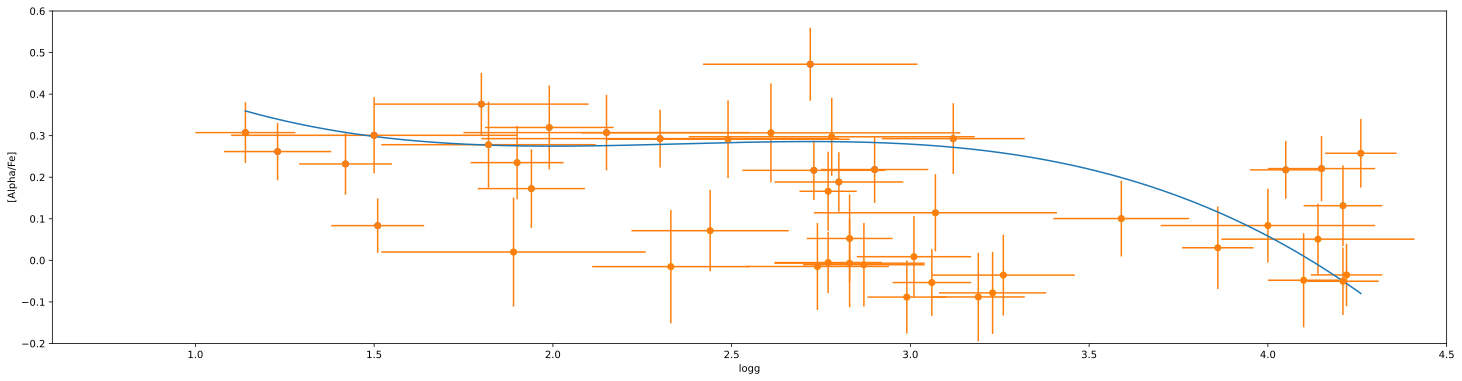

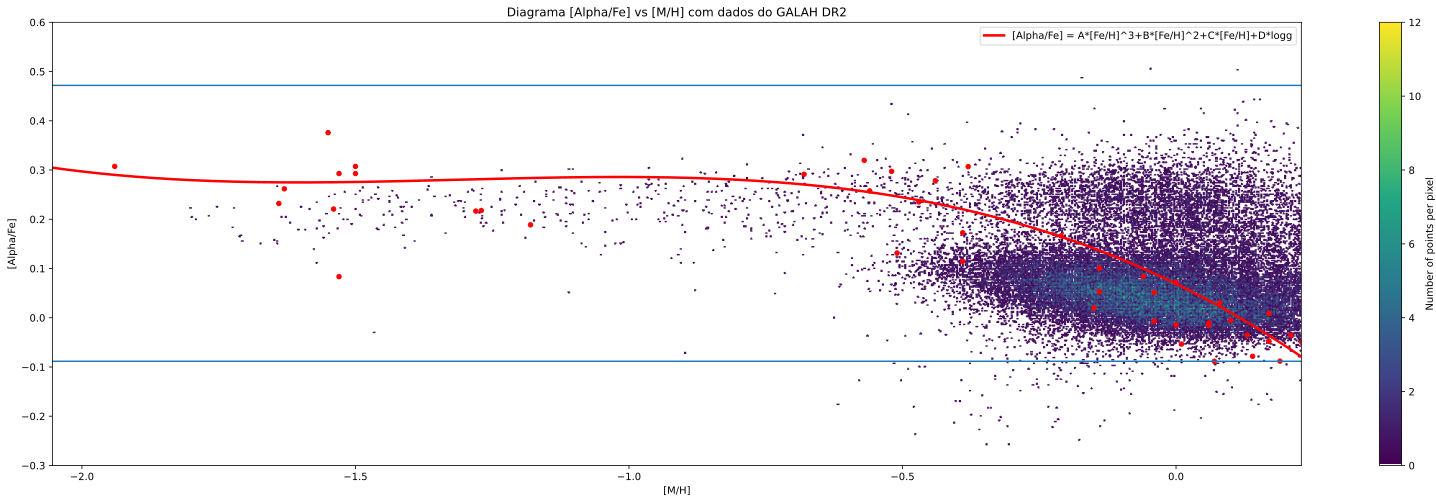

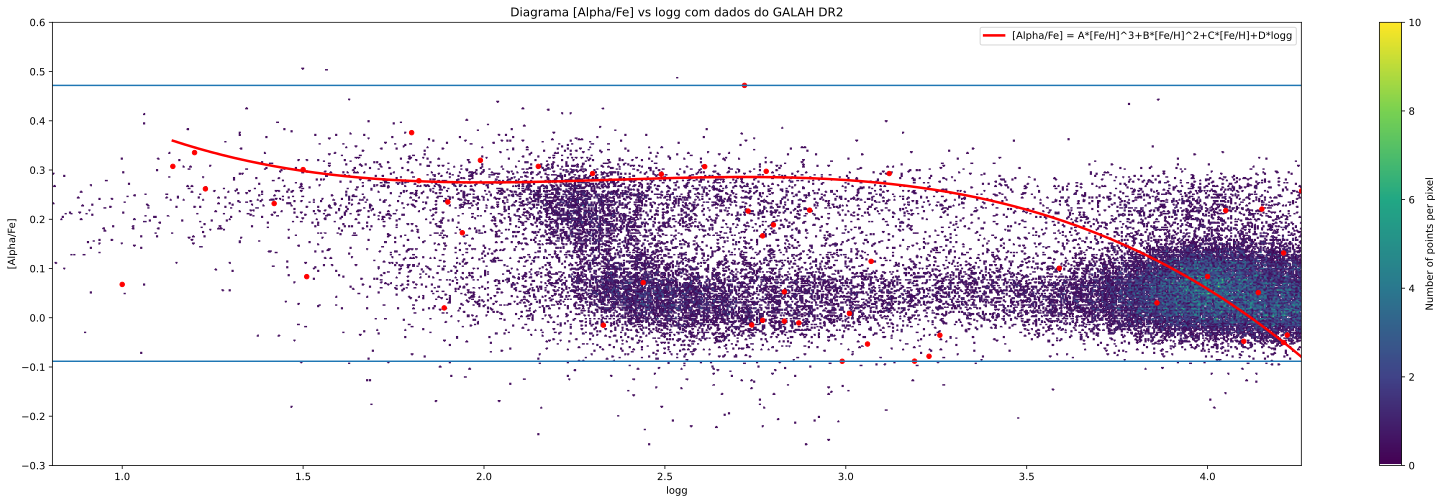

In [95]:
#Y=A*X2**3+B*X2**2+C*X2+D*X1         Red. ChiSq.=0.498386E-02
A=-.11057E+00 
B=-.43456E+00 
C=-.56229E+00   
D=0.17336E-01


alpha_fe = galah['alpha_fe']
m_h = galah['m_h']
logg_galah=galah['logg']

Y=[]
data1= data.drop(index=['HD_2796','HD_122563', 'HD_126587'] , axis=0)
alpha1_2009=alfa_def_2009.drop(index=['HD_2796','HD_122563', 'HD_126587'] , axis=0)
feh1=data1['[Fe/H]']
logg1=data1['LOGG']
vmic1=data1['VMIC']
erro_logg=data1['Δlogg']
erro_feh=data1['Δ[Fe/H]']



fehcont=np.linspace(np.amin(feh1), np.amax(feh1), num=1000)
loggcont=np.linspace(np.amin(logg1), np.amax(logg1), num=1000)
for j in range(len(fehcont)):
    y=A*fehcont[j]**3+B*fehcont[j]**2+C*fehcont[j]+D*loggcont[j]
    Y.append(y)
    
    
    
#PLOTANDO NO MATPLOTLIB    
plt.figure(figsize=(25, 6))
plt.plot(loggcont,Y)    
plt.scatter(logg1, unumpy.nominal_values(alpha1_2009), c=feh1)
plt.errorbar(logg1, unumpy.nominal_values(alpha1_2009), xerr=erro_logg, yerr=unumpy.std_devs(alpha1_2009),  fmt='o')

plt.ylabel('[Alpha/Fe]')
plt.xlabel('logg')
plt.ylim(-0.2, 0.6)
plt.xlim(0.6,4.5)

##PLOTANDO NO PLOTLY
fig=px.scatter(x=feh1, y=unumpy.nominal_values(alpha1_2009), color=vmic1, color_continuous_scale=px.colors.sequential.Turbo, error_x=erro_feh, error_y=unumpy.std_devs(alpha1_2009), hover_name=data1.index)
fig.update_traces(mode='markers', marker_line_width=2, marker_size=10)
fig.add_trace(go.Scatter(
        x=fehcont,
        y=Y,
        mode="lines",
        line=go.scatter.Line(color="red"),
        showlegend=False
        ))

fig.update_xaxes(title_text='[Fe/H]', range = [-2.5, 0.4])
fig.update_yaxes(title_text='[alpha/Fe]',range = [-0.2, 0.6] )

fig.show()

white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)
def using_mpl_scatter_density(fig, m_h, alpha_fe):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(m_h, alpha_fe, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')
fig = plt.figure()
plt.gcf().set_size_inches((28, 8))    
using_mpl_scatter_density(fig, m_h, alpha_fe)
plt.xlabel('[M/H]')
plt.ylabel('[Alpha/Fe]')
plt.title('Diagrama [Alpha/Fe] vs [M/H] com dados do GALAH DR2')
plt.scatter(feh, unumpy.nominal_values(alfa_def_2009), s=20, c='red')
plt.plot(fehcont,Y, c='red', linewidth=2.5, label='[Alpha/Fe] = A*[Fe/H]^3+B*[Fe/H]^2+C*[Fe/H]+D*logg')    
plt.hlines(min(unumpy.nominal_values(alfa_def_2009)), -3,2)
plt.hlines(max(unumpy.nominal_values(alfa_def_2009)), -3,2)
plt.ylim(-0.3, 0.6)
plt.legend()
plt.show()

def using_mpl_scatter_density(fig, logg_galah, alpha_fe):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(logg_galah, alpha_fe, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')
fig = plt.figure()
plt.gcf().set_size_inches((28, 8))    
using_mpl_scatter_density(fig, logg_galah, alpha_fe)
plt.xlabel('logg')
plt.ylabel('[Alpha/Fe]')
plt.title('Diagrama [Alpha/Fe] vs logg com dados do GALAH DR2')
plt.scatter(logg, unumpy.nominal_values(alfa_def_2009), s=20, c='red')
plt.plot(loggcont,Y, c='red', linewidth=2.5, label='[Alpha/Fe] = A*[Fe/H]^3+B*[Fe/H]^2+C*[Fe/H]+D*logg')    
plt.hlines(min(unumpy.nominal_values(alfa_def_2009)), 0,5)
plt.hlines(max(unumpy.nominal_values(alfa_def_2009)), 0,5)
plt.ylim(-0.3, 0.6)
plt.legend()

plt.show()

# Comparativo com Alonso

In [96]:
#Tratamento dos dados
alonso = pd.read_excel(r'C:\Users\joaow.000\Downloads\abundancias_def_def.ods', sheet_name='Alonso',  index_col=0)
teff_alonso=alonso['TEFF_ALONSO']
teff_alonso=teff_alonso.dropna()

logg_alonso=alonso['LOGG_ALONSO']
logg_alonso=logg_alonso.dropna()

feh_alonso=alonso['[FE/H]_ALONSO']
feh_alonso=feh_alonso.dropna()

teff_comp=teff.drop(index=['94_aqr'] , axis=0)
logg_comp=logg.drop(index=['94_aqr', 'Procyon_A', 'Bet_Com'] , axis=0)
feh_comp=feh.drop(index=['94_aqr', 'Procyon_A', 'Bet_Com'] , axis=0)

##FAZENDO A REGRESSÃO LINEAR DAS VARIÁVEIS
from sklearn.metrics import r2_score

regressao_teff = np.polyfit(teff_comp, teff_alonso, 1)
predict_teff = np.poly1d(regressao_teff)
r2_teff=r2_score(teff_alonso, predict_teff(teff_comp))

regressao_logg = np.polyfit(logg_comp, logg_alonso, 1)
predict_logg = np.poly1d(regressao_logg)
r2_logg=r2_score(logg_alonso, predict_logg(logg_comp))

regressao_feh = np.polyfit(feh_comp, feh_alonso, 1)
predict_feh = np.poly1d(regressao_feh)
r2_feh=r2_score(feh_alonso, predict_feh(feh_comp))


Y1=[]
teffcont=np.linspace(np.amin(teff), np.amax(teff), len(teff_comp))
for i in range(len(teffcont)):
    y=regressao_teff[0]*teffcont[i] + regressao_teff[1]
    Y1.append(y)

Y2=[]
loggcont=np.linspace(np.amin(logg), np.amax(logg), len(logg_comp))
for i in range(len(loggcont)):
    y=regressao_logg[0]*loggcont[i] + regressao_logg[1]
    Y2.append(y)
    
Y3=[]
fehcont=np.linspace(np.amin(feh), np.amax(feh), len(feh_comp))
for i in range(len(fehcont)):
    y=regressao_feh[0]*fehcont[i] + regressao_feh[1]
    Y3.append(y)    
    
    
#CRIANDO SUBGRÁFICOS    
fig = make_subplots(rows=3, cols=1, horizontal_spacing =0.04)

#Grafico TEFF
fig.add_trace(go.Scatter(x=teff_comp, y=teff_alonso, mode="markers+text"),row=1, col=1)
fig.add_trace(go.Scatter(x=teffcont, y=Y1, mode="lines", line=go.scatter.Line(color="red"), showlegend=False),row=1, col=1)

#Grafico logg
fig.add_trace(go.Scatter(x=logg_comp, y=logg_alonso, mode="markers+text"),row=2, col=1)
fig.add_trace(go.Scatter(x=loggcont, y=Y2, mode="lines", line=go.scatter.Line(color="red"), showlegend=False ),row=2, col=1)

#Grafico [Fe/H]
fig.add_trace(go.Scatter(x=feh_comp, y=feh_alonso, mode="markers+text"),row=3, col=1)
fig.add_trace(go.Scatter(x=fehcont,y=Y3, mode="lines", line=go.scatter.Line(color="red"),showlegend=False),row=3, col=1)

#Adicionando complementos aos gráficos
fig.update_layout(height=600, width=2000, title_text="Comparação dos parâmetros atmosféricos obtidos com amostra de A99")
fig.update_xaxes(title_text="Teff", row=1, col=1, tickfont_size= 18,titlefont_size=24)
fig.update_yaxes(title_text="Teff_A99", row=1, col=1, tickfont_size= 18, titlefont_size=24)
fig.update_xaxes(title_text="log(g)", row=2, col=1, tickfont_size= 18, titlefont_size=24)
fig.update_yaxes(title_text="log(g)_A99", row=2, col=1, tickfont_size= 18, titlefont_size=24)
fig.update_xaxes(title_text="[Fe/H]", row=3, col=1,tickfont_size= 18, titlefont_size=24)
fig.update_yaxes(title_text="[Fe/H]_A99", row=3, col=1, tickfont_size= 18, titlefont_size=24)
fig.add_annotation(x=4700,y=6300,text='R²=' + str(r2_teff), showarrow=False,bordercolor='black',borderwidth=1,bgcolor='white', row=1, col=1,  font=dict(size=24))
fig.add_annotation(x=1.5,y=3.8,text='R²=' + str(r2_logg), showarrow=False,bordercolor='black',borderwidth=1,bgcolor='white', row=2, col=1,  font=dict(size=24))
fig.add_annotation(x=-2.5,y=-0.2,text='R²=' + str(r2_feh), showarrow=False,bordercolor='black',borderwidth=1,bgcolor='white', row=3, col=1,  font=dict(size=24))
fig.update(layout_showlegend=False)
fig.update_layout(width=1800,height=2000)
fig.show()

# Gráfico teórico de [Alpha/Fe] vs [Fe/H]

In [97]:
fig = go.Figure(go.Scatter(x=[-1.75,-1, -0.25, 0.2], y=[0.35, 0.35,0 , 0] ))
fig.update_layout(scene = dict(
                    xaxis_title="[Fe/H]",
                    yaxis_title="[Alpha/Fe]"),width=1200,
                  height=700,)
fig.update_xaxes(title_text='[Fe/H]', range = [-1.75, 0.35],titlefont_size=24, tickfont_size= 18)
fig.update_yaxes(title_text=r'$\large{[\alpha / Fe]}$', range = [-0.05, 0.55], titlefont_size=18, tickfont_size= 18)

fig.add_annotation(x=-1.4, y=0.4, text="IMF ↑", showarrow=False, font=dict(size=24))
fig.add_annotation(x=-0.25,y=0.25,text="SFR →", showarrow=False,  font=dict(size=24))
fig.show()
fig.write_image("teste.pdf")

# Analisando dependência de [alpha/Fe] com [Fe/H] e log(g)  

In [98]:
tii_logg = px.scatter(y=tii, x=logg, hover_name=data.index, labels="Estrelas feitas", trendline="lowess", 
                 color=feh, color_continuous_scale=px.colors.sequential.Inferno, )
tii_logg.update_traces(marker=dict(size=10))
tii_logg.update_coloraxes(colorbar=dict(thickness=14, title="[Fe/H]",
                           ticklen=1, tickcolor='black',
                           tickfont=dict(size=20, color='black')))
tii_logg.update_xaxes(title_text='log(g)', titlefont_size=24, tickfont_size= 17)
tii_logg.update_yaxes(title_text='Ti II', titlefont_size=24, tickfont_size= 17)
tii_logg.write_image("logg_vs_tiii.pdf")
tii_logg.update_xaxes(mirror=True,
ticks='outside',
linewidth=2, linecolor='black')
tii_logg.update_yaxes(mirror=True,
ticks='outside',
linewidth=2, linecolor='black')
tii_logg.show()
tii_logg.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
tii_logg.update_layout(width=1700,height=800)
tii_logg.write_image("tii_logg.pdf")

In [99]:

tii_feh = px.scatter(y=tii, x=feh, hover_name=data.index, labels="Estrelas feitas", trendline="ols", 
                     color=logg, color_continuous_scale=px.colors.sequential.Inferno)
tii_feh.update_traces(marker=dict(size=10))
tii_feh.update_coloraxes(colorbar=dict(thickness=14, title="log(g)",
                           ticklen=1, tickcolor='black',
                           tickfont=dict(size=20, color='black')))
tii_feh.update_xaxes(title_text='[Fe/H]', titlefont_size=24, tickfont_size= 17)
tii_feh.update_yaxes(title_text='Ti II', titlefont_size=24, tickfont_size= 17)
tii_feh.write_image("logg_vs_tiii.pdf")
##COLOCANDO ANOTAÇÕES 
fit_results = px.get_trendline_results(tii_feh).px_fit_results.iloc[0]
linha1='Ti II = ' + str(round(fit_results.params[1], 4)) + '*[Fe/H] + ' + str(round(fit_results.params[0], 4))
linha2='R² = '+ str(round(fit_results.rsquared,4))
texto= linha1 + '<br>' + linha2

tii_feh.add_annotation(x=-2.65,y=5,text= texto, 
                   showarrow=False,bordercolor='black',borderwidth=1,bgcolor='white', font=dict(size=22))



## COLOCANDO BARRAS ENVOLTA E DEIXANDO FUNDO TRANSPARENTE
tii_feh.update_xaxes(mirror=True,
ticks='outside',
linewidth=2, linecolor='black')
tii_feh.update_yaxes(mirror=True,
ticks='outside',
linewidth=2, linecolor='black')
tii_feh.show()
tii_feh.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
tii_feh.update_layout(width=1700,height=800)
tii_feh.write_image("tii_feh.pdf")